In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [ ]:
import tensorflow as tf

class ClassWiseAccuracy(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='class_wise_accuracy', **kwargs):
        super(ClassWiseAccuracy, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.correct_counts = self.add_weight(name="correct_counts", shape=(num_classes,), initializer="zeros", dtype=tf.float32)
        self.total_counts = self.add_weight(name="total_counts", shape=(num_classes,), initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true: 실제 레이블
        # y_pred: 예측 확률
        y_pred_classes = tf.argmax(y_pred, axis=1, output_type=tf.int32)
        y_true = tf.cast(y_true, tf.int32)

        for i in range(self.num_classes):
            mask = tf.equal(y_true, i)
            class_correct = tf.reduce_sum(tf.cast(tf.logical_and(mask, tf.equal(y_true, y_pred_classes)), tf.float32))
            class_total = tf.reduce_sum(tf.cast(mask, tf.float32))

            self.correct_counts.assign(tf.tensor_scatter_nd_add(
                self.correct_counts, indices=[[i]], updates=[tf.reduce_sum(tf.cast(class_correct, tf.float32))]
            ))
            self.total_counts.assign(tf.tensor_scatter_nd_add(
                self.total_counts, indices=[[i]], updates=[tf.reduce_sum(tf.cast(class_total, tf.float32))]
            ))

    def result(self):
        return tf.where(self.total_counts > 0, self.correct_counts / self.total_counts, 0.0)

    def reset_states(self):
        self.correct_counts.assign(tf.zeros_like(self.correct_counts))
        self.total_counts.assign(tf.zeros_like(self.total_counts))

# ClassWiseAccuracy(num_classes=10)

### 코드 에러 정리..
```
AttributeError: 'SymbolicTensor' object has no attribute 'assign_add'
```
- 상황
  - 각 클래스마다 실제 레이블 개수와 모델이 예측한 레이블 개수를 담아야 함
  - 생성자에서 정의한 state variable인 `correct_counts`와 `total_counts`를 `add_weight()` 메소드로 초기화해줌
  - 각 인덱스에 접근해서 `correct_counts[i].assign_add()` 를 사용할 수 없음
- 원인
  - 해당 변수가 tf.Variable로 인식되지 않음
  - tf.function이나 tf.keras 모델이 그래프 모드로 실행될 때 발생 가능
- 해결 방법
  - `tf.tensor_scatter_nd_add`를 사용하여 상태 업데이트
- Ref.
  - [assign on a tf.Variable tensor slice](https://stackoverflow.com/questions/37583690/assign-on-a-tf-variable-tensor-slice#answer-37584068)

In [ ]:
def get_mnist_model():
    inputs = keras.Input(shape=(28*28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255

val_images = train_images[:10000]
val_labels = train_labels[:10000]
train_images = train_images[10000:]
train_labels = train_labels[10000:]

In [ ]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", ClassWiseAccuracy(num_classes=10)])

# model.fit(train_images, train_labels, epochs=3,validation_data=(val_images, val_labels))
# test_metrics = model.evaluate(test_images, test_labels)
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
print("Test metrics:", test_metrics)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8688 - class_wise_accuracy: 0.8672 - loss: 0.4476 - val_accuracy: 0.9591 - val_class_wise_accuracy: 0.9585 - val_loss: 0.1443
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9511 - class_wise_accuracy: 0.9506 - loss: 0.1633 - val_accuracy: 0.9686 - val_class_wise_accuracy: 0.9685 - val_loss: 0.1168
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9608 - class_wise_accuracy: 0.9605 - loss: 0.1304 - val_accuracy: 0.9727 - val_class_wise_accuracy: 0.9725 - val_loss: 0.1009
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9691 - class_wise_accuracy: 0.9687 - loss: 0.1081 - val_accuracy: 0.9741 - val_class_wise_accuracy: 0.9737 - val_loss: 0.1036
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 0.9733 - class_wise_accuracy: 0.9731 - loss: 0.0972 - val_accuracy: 0.9772 - val_class_wise_accuracy: 0.9771 - val_loss: 0.0947
Epoch 6/10
1563/1563

In [ ]:
history.history

{'accuracy': [0.9141200184822083,
  0.9543200135231018,
  0.9622600078582764,
  0.9685800075531006,
  0.9725599884986877,
  0.973800003528595,
  0.9773399829864502,
  0.9782999753952026,
  0.9783999919891357,
  0.9802600145339966],
 'class_wise_accuracy': [<tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([0.9555059 , 0.96972394, 0.90819407, 0.88605607, 0.91608393,
         0.8753839 , 0.94963294, 0.9185755 , 0.8734461 , 0.8790988 ],
        dtype=float32)>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([0.9766355 , 0.97898483, 0.9496678 , 0.9350853 , 0.95475113,
         0.9401053 , 0.9726754 , 0.9578441 , 0.935806  , 0.93783945],
        dtype=float32)>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([0.9766355 , 0.98165625, 0.9619489 , 0.9486174 , 0.9613328 ,
         0.94975865, 0.97920066, 0.9653513 , 0.94823724, 0.9466908 ],
        dtype=float32)>,
  <tf.Tensor: shape=(10,), dtype=float32, numpy=
  array([0.98252743, 0.98521817, 0.97121   , 0.9550892 , 

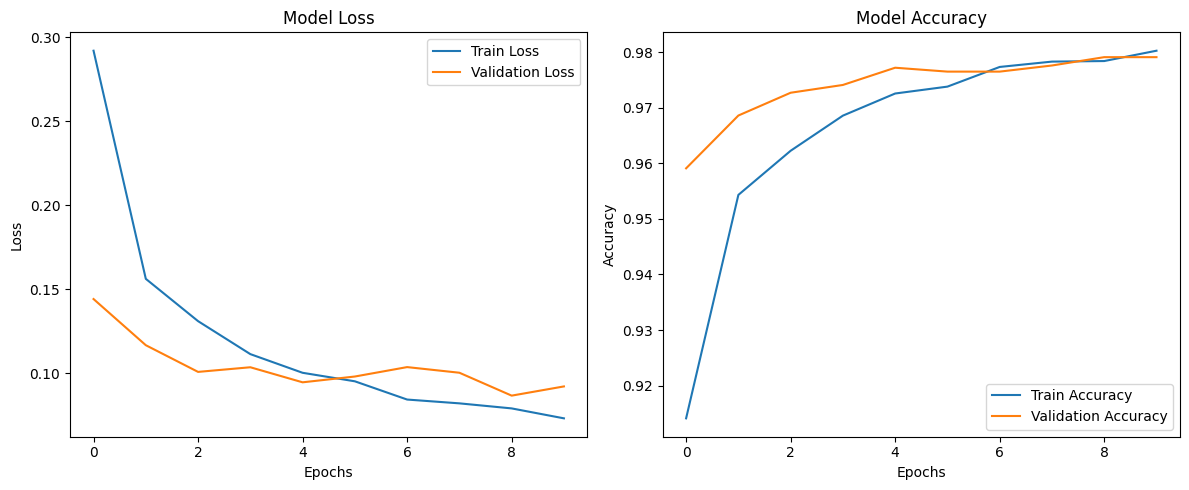

In [ ]:
import matplotlib.pyplot as plt

# 훈련 히스토리에서 손실 및 정확도 데이터 가져오기
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history.get('accuracy', [])
val_accuracy = history.history.get('val_accuracy', [])

# 손실 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프 (accuracy key가 있는 경우)
if train_accuracy and val_accuracy:
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from tensorflow.keras.datasets import imdb
(train_data, train_labels), _ = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results
train_data = vectorize_sequences(train_data)

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
# model.compile(optimizer="rmsprop",
#               loss="binary_crossentropy",
#               metrics=["accuracy"])
# history_original = model.fit(train_data, train_labels,
#                              epochs=20, batch_size=512, validation_split=0.4)

In [5]:
import tensorflow as tf

class MyMetric(keras.metrics.Metric):
    def __init__(self, name="accuracy2", **kwargs):
        super().__init__(name=name, **kwargs)
        self.abs_sum = self.add_weight(name="abs_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples", initializer="zeros", dtype="int32")

	  # GPU 가속 기능이 있는 TensorFlow에서 에러 발생 (TensorFlow 2.17)
    def update_state(self, y_true, y_pred, sample_weight=None):
        tf.print("y_true:", y_true)
        tf.print("y_pred:", y_pred)
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.round(y_pred)
        y_pred = tf.squeeze(y_pred, axis=-1)
        abs_sum = tf.reduce_sum(tf.abs(y_true - y_pred))
        self.abs_sum.assign_add(abs_sum)
        num_samples = tf.shape(y_pred)[0]
        #num_samples = y_pred.shape[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        #return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
        return self.abs_sum / tf.cast(self.total_samples, tf.float32)

    def reset_state(self):
        self.abs_sum.assign(0.)
        self.total_samples.assign(0)

In [6]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=[MyMetric()])
history_original = model.fit(train_data, train_labels,
                             epochs=20, batch_size=512, validation_split=0.4)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy2: 0.3115 - loss: 0.6277 - val_accuracy2: 0.1614 - val_loss: 0.4524
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy2: 0.1134 - loss: 0.3927 - val_accuracy2: 0.1187 - val_loss: 0.3390
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy2: 0.0904 - loss: 0.2819 - val_accuracy2: 0.1184 - val_loss: 0.3028
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy2: 0.0685 - loss: 0.2186 - val_accuracy2: 0.1104 - val_loss: 0.2807
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy2: 0.0593 - loss: 0.1826 - val_accuracy2: 0.1106 - val_loss: 0.2764
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy2: 0.0482 - loss: 0.1542 - val_accuracy2: 0.1128 - val_loss: 0.2815
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy2: 0.0430 - loss: 0.1351 - val_accuracy2: 0.1119 - val_loss: 0.2875
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy2: 0.0335 - loss: 0.1139 - val_accur

#### 코드 에러 정리 2..
- 상황
  - custom metric `MyMetric`을 사용하면 `accuracy2: 255.xxx`와 같이 큰 값이 나옴
- 원인
  - `y_true`와 `y_pred`을 찍어봤을 때 서로 다른 쉐잎을 가지고 있었음
  - shape
  ```
  y_true: Tensor("Cast_1:0", shape=(None,), dtype=float32)
  y_pred: Tensor("Round:0", shape=(None, 1), dtype=float32)
  ```
  - value (`tf.print()`로 출력 가능)
  ```
  y_true: [1 0 1 ... 0 1 0]
  y_pred: [[1]
  [0]
  [1]
  ...
  [0]
  [1]
  [0]]
  ```
- 해결 방법
  - `y_pred = tf.squeeze(y_pred, axis=-1)`을 이용하여, `y_pred`의 차원을 2D에서 1D로 불필요한 차원을 제거해줌